In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import itertools
from time import sleep
import os
import seaborn as sns
from itertools import chain

In [2]:
print datetime.datetime.now()
validFilePaths = []
for f in os.listdir("data/anomaly_data"):
    filePath = os.path.join("data/anomaly_data", f)
    if os.path.isdir(filePath):
        continue
    if os.stat(filePath).st_size <= 3:
        continue
    validFilePaths.append(filePath)
    
numF = int(1 * len(validFilePaths))
print 'Using this many files {0}'.format(numF)
validFilePaths = np.random.choice(validFilePaths, numF, replace=False)
df_list = (pd.read_csv(f) for f in validFilePaths)
df = pd.concat(df_list, ignore_index=True)
df = df[df['radiant_win'].notnull()]

2017-06-14 00:54:41.074382
Using this many files 4088


In [3]:
df2 = pd.DataFrame(np.loadtxt('data/goodAnomaliesResidual.csv', delimiter = ','), 
                 columns = ["match_id", "residual"])

df = df.merge(df2, left_on='match_id', right_on='match_id')

matchDictionary = {}
heroColumns = [filter(lambda x: z in x, df.columns) for z in ['hero_id']][0]

# for each row, this function will return all the heroes that the match belongs in
# for example, if the match had an AM and Spectre, we should place this match in each of those bags
def heroesForMatch(row):
    pass

In [4]:
df = df[~df['match_id'].duplicated()]

In [5]:
df = df.sort_values(by='residual', ascending=False)

In [6]:
columns = df.columns
numericalFeatures = ['match_id', 'positive_votes', 'negative_votes', 'first_blood_time', 'radiant_win',
                    'duration', 'kills', 'deaths', 'assists', 'kpm', 'kda', 'hero_dmg',
                    'gpm', 'hero_heal', 'xpm', 'totalgold', 'totalxp', 'lasthits', 'denies',
                    'tower_kills', 'courier_kills', 'observer_uses', 'sentry_uses',
                    'ancient_kills', 'camps_stacked', 'abandons', 'residual']
numFeatures = [filter(lambda x: z in x, columns) for z in numericalFeatures]
numFeatures = list(chain(*numFeatures))
df = df[numFeatures]

In [7]:
df['match_id'].values.tolist()

[3215497967,
 3215097220,
 3215312675,
 3215162338,
 3215181105,
 3215377994,
 3215271631,
 3215289100,
 3215279863,
 3215253055,
 3215448302,
 3215416370,
 3215261563,
 3215294948,
 3215155134,
 3215350255,
 3215341221,
 3215306187,
 3215302636,
 3215316820,
 3215190109,
 3215355847,
 3215130854,
 3215259897,
 3215394671,
 3215152225,
 3215274711,
 3215366609,
 3215449992,
 3215376405,
 3215268540,
 3215420902,
 3215332931,
 3215327547,
 3215354992,
 3215254939,
 3215149372,
 3215370025,
 3215201012,
 3215272070,
 3215223639,
 3215422492,
 3215260456,
 3215354934,
 3215377592,
 3215445972,
 3215101148,
 3215174827,
 3215384305,
 3215188370,
 3215297782,
 3215493515,
 3215119808,
 3215360521,
 3215102154,
 3215271055,
 3215403667,
 3215217460,
 3215482564,
 3215466626,
 3215255292,
 3215095789,
 3215108689,
 3215330831,
 3215468550,
 3215446132,
 3215384555,
 3215470445,
 3215318005,
 3215238829,
 3215293087,
 3215391855,
 3215439074,
 3215401870,
 3215440922,
 3215092973,
 3215369622,

In [8]:
df['residual'].values.tolist()

[60.09383010864258,
 22.98058319091797,
 14.018461227416992,
 12.276541709899902,
 10.960655212402344,
 10.190336227416992,
 9.797115325927734,
 8.665862083435059,
 8.291083335876465,
 6.753566265106201,
 5.982767105102539,
 5.009283542633057,
 4.787799835205078,
 4.737585544586182,
 4.151325702667236,
 3.8586721420288086,
 3.7200565338134766,
 3.653451919555664,
 3.6120126247406006,
 3.55796217918396,
 3.5249321460723877,
 3.4550528526306152,
 3.4301578998565674,
 2.9261271953582764,
 2.8132457733154297,
 2.767648220062256,
 2.758488178253174,
 2.543581247329712,
 2.5158803462982178,
 2.4831578731536865,
 2.4762089252471924,
 2.392141342163086,
 2.38230299949646,
 2.3297765254974365,
 2.2398288249969482,
 2.229811429977417,
 2.1894421577453613,
 2.1700241565704346,
 2.150897741317749,
 2.0817346572875977,
 2.0602142810821533,
 2.044538974761963,
 2.038116693496704,
 2.0010886192321777,
 1.953024983406067,
 1.9425238370895386,
 1.919196367263794,
 1.8698474168777466,
 1.823149442672729

In [9]:
np.percentile(df['residual'], .99)

0.084894262730330225

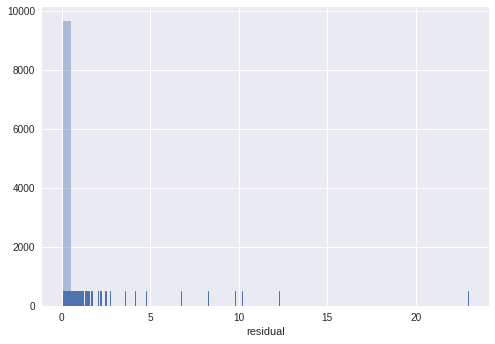

In [10]:
sns.distplot(df['residual'].sample(n=10000),  kde=False, rug=True)
plt.show()

In [11]:
len(df)

42798

In [12]:
plt.close()

In [13]:
residuals = df['residual'].values.tolist()

In [14]:
np.max(residuals) - np.min(residuals)

60.033355519175529

In [15]:
df['residual']

25569    60.093830
27213    22.980583
7624     14.018461
29500    12.276542
20061    10.960655
19523    10.190336
5883      9.797115
5841      8.665862
27811     8.291083
40122     6.753566
21074     5.982767
1041      5.009284
26025     4.787800
26424     4.737586
805       4.151326
9761      3.858672
22658     3.720057
28717     3.653452
28810     3.612013
12816     3.557962
29707     3.524932
451       3.455053
33087     3.430158
12558     2.926127
30075     2.813246
23889     2.767648
2082      2.758488
26318     2.543581
2581      2.515880
5693      2.483158
           ...    
31410     0.069483
40625     0.069253
32092     0.069227
37381     0.069197
3267      0.069074
20827     0.069049
34031     0.068937
6262      0.068805
21725     0.068641
25821     0.068497
3392      0.068060
13112     0.067955
11352     0.067766
34846     0.067643
10153     0.067419
1759      0.066208
2237      0.065560
5963      0.065004
20984     0.064927
39749     0.064823
16058     0.064179
23064     0.

In [16]:
def RadiantDireDifference(row, column):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    radiantSum = 0
    direSum = 0
    for pos in poss:
        radiantSum += row['radiant_'+ pos + '_' + column]
        direSum += row['dire_'+ pos + '_' + column]
    return radiantSum - direSum

def reject_outliers(data, m=1.5):
    return abs(data - np.mean(data)) < m * np.std(data)


def heroKDAdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] + \
                        row[fac + '_' + pos + '_assists'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def heroKDdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def heroKD(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = int(pos[3:4])
    return returnVal

def heroGoldSpent(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_gold_spent']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = int(pos[3:4])
    return returnVal

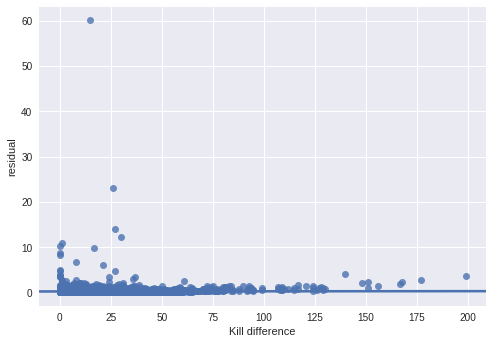

In [17]:
kill_difference = np.abs(df.apply(RadiantDireDifference, args=('kills',), axis=1))
sns.regplot(kill_difference, df['residual'])
ax = plt.gca()
ax.set_xlabel("Kill difference")
plt.show()

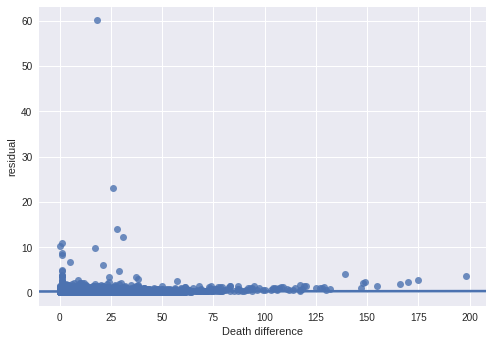

In [18]:
death_difference = df.apply(RadiantDireDifference, args=('deaths',), axis=1)
sns.regplot(np.abs(death_difference), df['residual'])
ax = plt.gca()
ax.set_xlabel("Death difference")
plt.show()

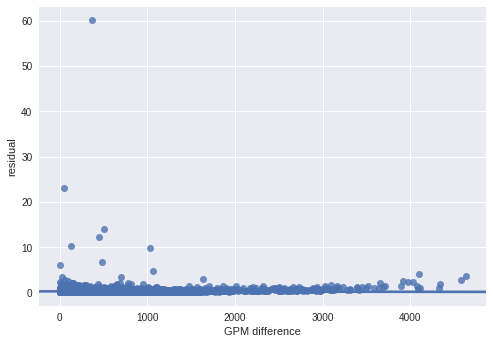

In [19]:
gold_difference = df.apply(RadiantDireDifference, args=('gpm',), axis=1)
above_ = np.abs(gold_difference) <= 5000

indices = np.where(above_)[0]
sns.regplot(np.abs(gold_difference)[above_], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("GPM difference")
plt.show()

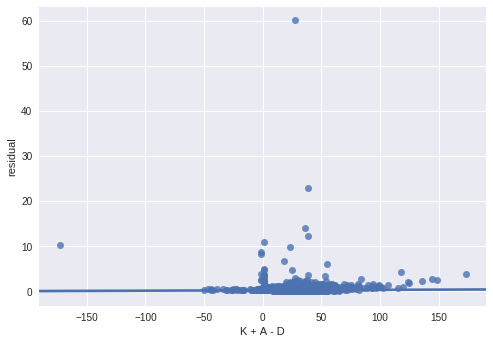

In [20]:
kda = df.apply(heroKDAdeficit, axis=1)
sns.regplot(kda, df['residual'])
ax = plt.gca()
ax.set_xlabel("K + A - D")
plt.show()

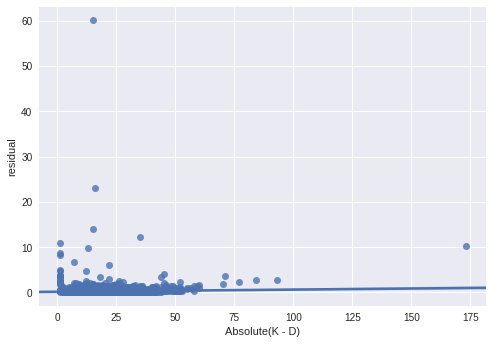

In [21]:
kd = df.apply(heroKDdeficit, axis=1)
sns.regplot(np.abs(kd), df['residual'])
ax = plt.gca()
ax.set_xlabel("Absolute(K - D)")
plt.show()

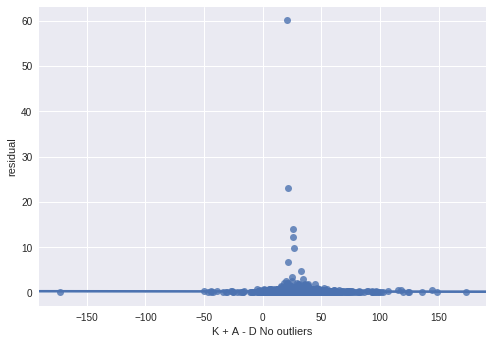

In [22]:
kda = df.apply(heroKDAdeficit, axis=1)
kda_mean = np.mean(kda)
kda_std = np.std(kda)
indices = np.where(np.logical_and(kda <= kda_mean + 1.5*kda_std, kda >= kda_mean-1.5*kda_std))[0]
sns.regplot(kda[indices], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("K + A - D No outliers")
plt.show()

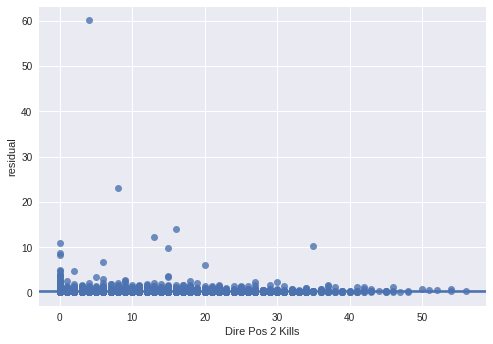

In [23]:
sns.regplot(df['dire_pos2_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Dire Pos 2 Kills")
plt.show()

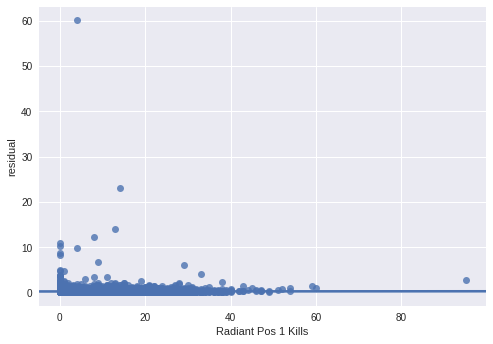

In [24]:
sns.regplot(df['radiant_pos1_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills")
plt.show()

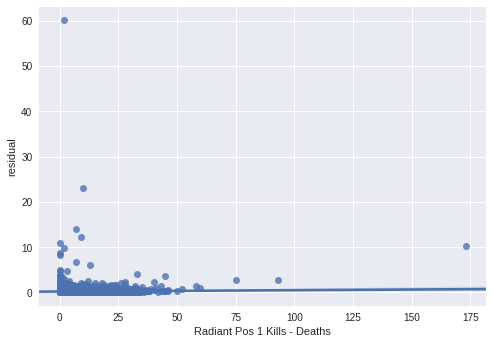

In [25]:
sns.regplot(np.abs(df['radiant_pos1_kills'] - df['radiant_pos1_deaths']), df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills - Deaths")
plt.show()

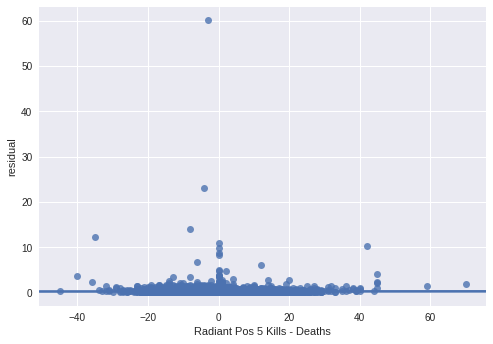

In [26]:
sns.regplot(df['radiant_pos5_kills'] - df['radiant_pos5_deaths'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 5 Kills - Deaths")
plt.show()

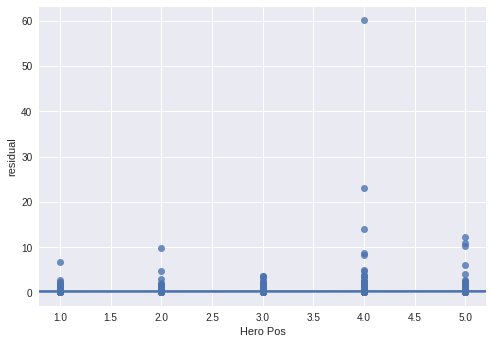

In [27]:
sns.regplot(df.apply(heroKD, axis=1), df['residual'])
ax = plt.gca()
ax.set_xlabel("Hero Pos")
plt.show()

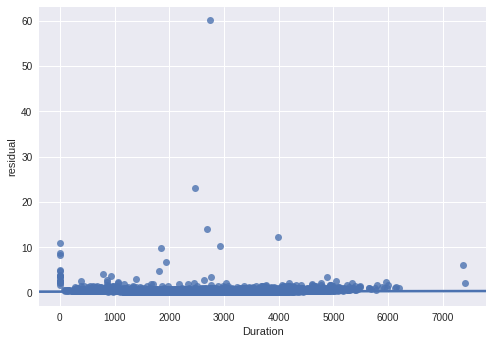

In [28]:
sns.regplot(df['duration'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Duration")
plt.show()

In [29]:
df[df['residual'] > 0.0848]

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
25569,3215497967,49,2,14,True,2748,43.0,0.0,4,141.0,...,0,0,0,0,0,0,0,0,0,60.093830
27213,3215097220,15,7,15,True,2470,23.0,0.0,7,108.0,...,0,0,0,0,0,0,0,0,0,22.980583
7624,3215312675,9,4,0,False,2687,0.0,0.0,10,9.0,...,0,0,0,0,0,0,0,0,0,14.018461
29500,3215162338,0,0,135,False,3981,18.0,21.0,27,70.0,...,0,0,0,0,0,0,0,0,0,12.276542
20061,3215181105,0,0,0,True,0,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,1,0,10.960655
19523,3215377994,0,0,72,False,2924,NaN,NaN,28,NaN,...,0,0,0,0,0,0,0,0,0,10.190336
5883,3215271631,7,1,3,False,1846,4.0,0.0,5,36.0,...,0,0,0,0,0,0,0,0,0,9.797115
5841,3215289100,0,0,0,False,0,NaN,NaN,0,NaN,...,0,0,1,0,0,0,0,0,0,8.665862
27811,3215279863,0,0,0,False,0,NaN,NaN,0,NaN,...,0,0,1,0,0,0,0,0,0,8.291083
40122,3215253055,5,0,182,True,1949,0.0,0.0,4,10.0,...,0,0,0,0,0,0,0,0,0,6.753566


In [30]:
df[df['residual'] < 0.0848].sample(10, random_state=1)

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
35366,3215372924,0,0,297,True,2784,NaN,NaN,11,NaN,...,0,0,0,0,0,0,0,0,0,0.080606
27407,3215381301,0,0,223,True,2472,NaN,NaN,6,NaN,...,0,0,0,0,0,0,0,0,0,0.073452
30292,3215334735,0,0,55,True,2588,NaN,NaN,5,NaN,...,0,0,0,0,0,0,0,0,0,0.078948
13285,3215279303,0,0,53,True,2320,NaN,NaN,7,NaN,...,0,0,0,0,0,0,0,0,0,0.080570
27196,3215268110,0,0,212,True,2641,NaN,NaN,4,NaN,...,0,0,0,0,0,0,0,0,0,0.080390
28149,3215110553,0,0,107,True,2615,NaN,NaN,9,NaN,...,0,0,0,0,0,0,0,0,0,0.079385
23141,3215467807,0,0,168,True,3080,NaN,NaN,12,NaN,...,0,0,0,0,0,0,0,0,0,0.084693
31639,3215395745,0,0,69,True,2574,NaN,NaN,8,NaN,...,0,0,0,0,0,0,0,0,0,0.076762
29543,3215157813,0,0,73,True,2940,NaN,NaN,7,NaN,...,0,0,0,0,0,0,0,0,0,0.072052
41335,3215182326,0,0,165,True,2534,NaN,NaN,6,NaN,...,0,0,0,0,0,0,0,0,0,0.074942


In [31]:
biggestAnom = np.loadtxt('data/anomalies.csv', delimiter = ',')
theirOutput = np.loadtxt('data/output.csv', delimiter = ",")

In [32]:
biggestAnom = np.column_stack([df['match_id'].values, biggestAnom])
theirOutput = np.column_stack([df['match_id'].values, theirOutput])

In [33]:
def whichIndex(row1, row2):
    largestError = -1
    index = -1
    for i in range(1, len(row1)):
        if abs(row1[i] - row2[i]) > largestError:
            largestError = abs(row1[i] - row2[i])
            index = i
    return index
columns = list(df.columns)
columns.remove('match_id')
for i in range(len(biggestAnom)):
    index = whichIndex(biggestAnom[i, :], theirOutput[i, :])
    if df.iloc[i]['residual'] >= 0.08489:
        print int(biggestAnom[i, 0]), columns[index], biggestAnom[i, index], theirOutput[i, index]

3215497967 negative_votes 49.0 1.0
3215097220 negative_votes 15.0 1.0
3215312675 negative_votes 9.0 1.0
3215162338 dire_pos5_courier_kills 0.997236430645 0.254108220339
3215181105 radiant_pos3_gpm 0.967831552029 0.215277791023
3215377994 dire_pos5_kda 0.986187636852 0.675353765488
3215271631 negative_votes 7.0 1.0
3215289100 dire_pos4_gpm 0.915403366089 0.162800624967
3215279863 dire_pos4_gpm 0.915403366089 0.155206382275
3215253055 negative_votes 5.0 1.0
3215448302 radiant_pos1_sentry_uses 0.977942168713 0.730815529823
3215416370 dire_pos3_gpm 0.0236208867282 0.595808267593
3215261563 radiant_pos3_gpm 0.243853777647 0.536930799484
3215294948 negative_votes 4.0 0.999999940395
3215155134 radiant_pos5_kills 0.996014475822 0.729707717896
3215350255 radiant_pos4_gpm 0.172037020326 0.478152662516
3215341221 radiant_pos1_kpm 0.765351176262 0.473023504019
3215306187 radiant_pos2_gpm 0.796920537949 0.594073414803
3215302636 dire_pos4_gpm 0.995038449764 0.616404891014
3215316820 dire_pos5_gpm 0

KeyboardInterrupt: 